# Model testing

Evaluate the saved XGBoost regressor on the held-out test dataset.

In [132]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [133]:
useBackslash = False
testDatasetPath = r'..\data\test_dataset_num_votes_log_over_1000.csv' if useBackslash else r'../data/test_dataset_num_votes_log_over_1000.csv'
final_model = joblib.load("xgb_reg_movie_score_cv_tweedie_rmae_over_1000.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


In [134]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

In [136]:
X_test = df_test.drop(columns = drop_cols)

In [ ]:
# Load model and data
y_true = df_test[target_col].values if target_col in df_test.columns else None
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])

print(f"Loaded test set with shape {df_test.shape}; features shape {X_test.shape}")


Loaded test set with shape (9340, 126); features shape (9340, 121)


In [138]:
# Predict
y_pred = final_model.predict(X_test)
print("Predictions generated.")

Predictions generated.


In [139]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  0.7135
RMSE: 0.9358
R2:   0.4924


In [141]:
y_true.mean()

np.float64(8.389007653923253)

In [142]:
y_pred.mean()

np.float32(8.423582)

In [140]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


In [143]:
importances = final_model.feature_importances_

# Feature names (if trained with a DataFrame)
feature_names = final_model.feature_names_in_

# Create sorted DataFrame
top_10_features = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(10)
)

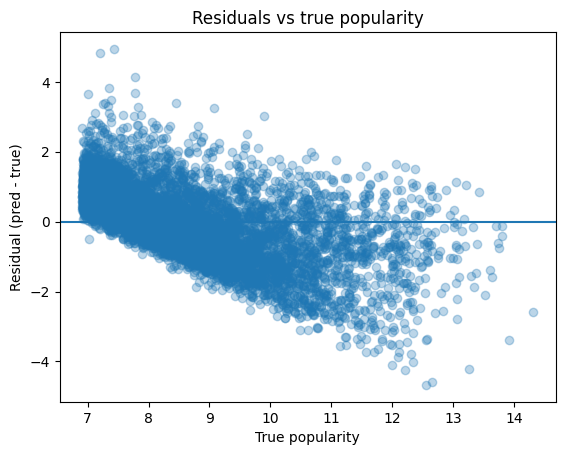

In [144]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


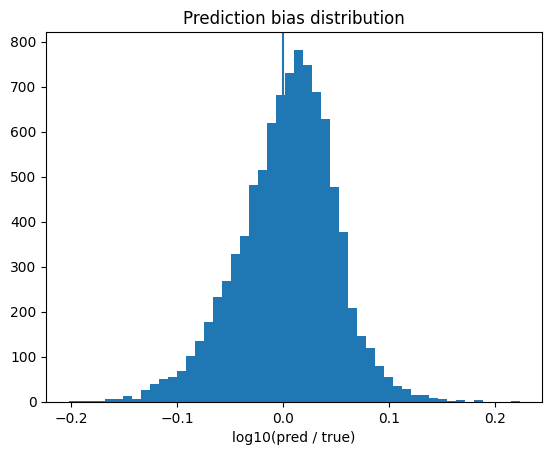

In [145]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()



In [146]:
import pandas as pd

df = pd.DataFrame({
    "true": y_true,
    "pred": y_pred
})

df["bin"] = pd.qcut(df["true"], q=10)

bias_by_bin = df.groupby("bin").apply(
    lambda x: np.mean(x["pred"] - x["true"])
)

print(bias_by_bin)


bin
(6.909, 7.077]     0.836897
(7.077, 7.276]     0.734336
(7.276, 7.493]     0.574004
(7.493, 7.709]     0.363494
(7.709, 7.995]     0.233553
(7.995, 8.335]     0.029031
(8.335, 8.77]     -0.178920
(8.77, 9.386]     -0.485542
(9.386, 10.34]    -0.745656
(10.34, 14.314]   -1.016965
dtype: float64


C:\Users\ander\AppData\Local\Temp\ipykernel_18968\2919763256.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_by_bin = df.groupby("bin").apply(
C:\Users\ander\AppData\Local\Temp\ipykernel_18968\2919763256.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_by_bin = df.groupby("bin").apply(
